# Dissimilarity Metric-based Channel Charting

## Imports

In [1]:
!mkdir results/channel_charting

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy.sparse.csgraph
import sklearn.neighbors
import scipy.spatial
import random
import tqdm
from scipy.spatial import distance_matrix

## Load Dataset

In [2]:
# time domain CSI
start_tap = 27
stop_tap = 40

csi_time_domain_RAW = np.load("dataset/csi_time_domain_RAW.npy")[...,start_tap:stop_tap]
csi_time_domain_RAW_RECOVERED = np.load("dataset/csi_time_domain_RAW_RECOVERED.npy")[...,start_tap:stop_tap]

csi_time_domain_RAW_test = np.load("dataset/csi_time_domain_RAW_test.npy")[...,start_tap:stop_tap]
csi_time_domain_RAW_RECOVERED_test = np.load("dataset/csi_time_domain_RAW_RECOVERED_test.npy")[...,start_tap:stop_tap]
csi_time_domain_OBFUSCATED_test = np.load("dataset/csi_time_domain_OBFUSCATED_test.npy")[...,start_tap:stop_tap]
csi_time_domain_RECOVERED_test = np.load("dataset/csi_time_domain_RECOVERED_test.npy")[...,start_tap:stop_tap]

# timestamps
timestamps = np.load("dataset/timestamps.npy")
timestamps_test = np.load("dataset/timestamps_test.npy")

# ground truth positions
groundtruth_positions = np.load("dataset/groundtruth_positions.npy")
groundtruth_positions_test = np.load("dataset/groundtruth_positions_test.npy")

groundtruth_positions = groundtruth_positions[:,:2]
groundtruth_positions_test = groundtruth_positions_test[:,:2]

## Visualizing the Dataset

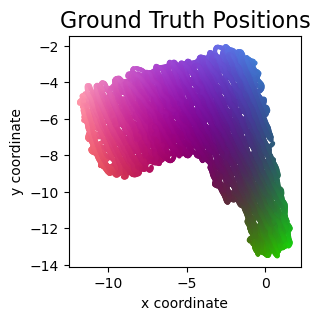

In [3]:
def plot_colorized(positions, groundtruth_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(groundtruth_positions[:, 0], axis = 0) + np.max(groundtruth_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(groundtruth_positions[:, 1], axis = 0) + np.max(groundtruth_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((groundtruth_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(groundtruth_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(groundtruth_positions[:,:2] - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(groundtruth_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(3, 3))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

plot_colorized(groundtruth_positions[:,:2], groundtruth_positions[:,:2], title="Ground Truth Positions")

## Dissimilarity Metrics and Dissimilarity Matrix Computation

### Step 1: ADP-based dissimilarity matrix

In [4]:
def get_adp_dissimilarity_matrix(csi_time_domain):

    adp_dissimilarity_matrix = np.zeros((csi_time_domain.shape[0], csi_time_domain.shape[0]), dtype=np.float32)
    
    def adp_dissimilarities_worker(todo_queue, output_queue):
        def adp_dissimilarities(index):
            # h has shape (arrays, antenna rows, antenna columns, taps), w has shape (datapoints, arrays, antenna rows, antenna columns, taps)
            h = csi_time_domain[index]
            w = csi_time_domain[index:]
    
            dotproducts = np.abs(np.einsum("brmt,lbrmt->lbt", np.conj(h), w))**2
            norms = np.real(np.einsum("brmt,brmt->bt", h, np.conj(h)) * np.einsum("lbrmt,lbrmt->lbt", w, np.conj(w)))
            
            return np.sum(1 - dotproducts / norms, axis = (1, 2))
    
        while True:
            index = todo_queue.get()
    
            if index == -1:
                output_queue.put((-1, None))
                break
            
            output_queue.put((index, adp_dissimilarities(index)))
    
    with tqdm.tqdm(total = csi_time_domain.shape[0]**2) as bar:
        todo_queue = mp.Queue()
        output_queue = mp.Queue()
    
        for i in range(csi_time_domain.shape[0]):
            todo_queue.put(i)
        
        for i in range(mp.cpu_count()):
            todo_queue.put(-1)
            p = mp.Process(target = adp_dissimilarities_worker, args = (todo_queue, output_queue))
            p.start()
    
        finished_processes = 0
        while finished_processes != mp.cpu_count():
            i, d = output_queue.get()
    
            if i == -1:
                finished_processes = finished_processes + 1
            else:
                adp_dissimilarity_matrix[i,i:] = d
                adp_dissimilarity_matrix[i:,i] = d
                bar.update(2 * len(d) - 1)

    return adp_dissimilarity_matrix

In [5]:
# Calculate dissimilarity matrices for RAW and RAW RECOVERED CSI
adp_dissimilarity_matrix_RAW = get_adp_dissimilarity_matrix(csi_time_domain_RAW)
adp_dissimilarity_matrix_RAW_RECOVERED = get_adp_dissimilarity_matrix(csi_time_domain_RAW_RECOVERED)

100%|██████████| 434764201/434764201 [04:45<00:00, 1521127.87it/s]


### Step 2: Timestamp-based dissimilarity matrix

In [6]:
# Compute timestamp-based dissimilarity matrix
timestamp_dissimilarity_matrix = np.abs(np.subtract.outer(timestamps, timestamps))

### Step 3: Fusing $\mathbf D_\mathrm{ADP}$ with $\mathbf D_\mathrm{time}$

In [7]:
def fuse_adp_time_dissimilarities(timestamp_dm, adp_dm):
    
    TIME_THRESHOLD = 2
    small_time_dissimilarity_indices = np.logical_and(timestamp_dm < TIME_THRESHOLD, timestamp_dm > 0)
    small_time_dissimilarities = timestamp_dm[small_time_dissimilarity_indices]
    small_adp_dissimilarities = adp_dm[small_time_dissimilarity_indices]
    
    occurences, edges = np.histogram(small_adp_dissimilarities / small_time_dissimilarities, range = (0, 50), bins = 1500)

    bin_centers = edges[:-1] + np.diff(edges) / 2.
    max_bin = np.argmax(occurences)
    min_threshold = np.quantile(occurences[:max_bin], 0.5)
    
    for threshold_bin in range(max_bin - 1, -1, -1):
        if occurences[threshold_bin] < min_threshold:
            break
    
    scaling_factor = bin_centers[threshold_bin]

    plt.figure(figsize=(5,3))

    plt.bar(bin_centers[:max_bin], occurences[:max_bin], width = edges[1] - edges[0])
    plt.axhline(y = min_threshold, color = 'r', linestyle = '-')                                       
    plt.text(4, min_threshold + 10, "Mode Separation Threshold", color = 'r',)
    plt.axvline(x = scaling_factor, color = 'r', linestyle = '-')
    plt.xlabel("$D_\mathrm{APDP} / D_\mathrm{time}$")
    plt.ylabel("Number of Occurences")
    plt.show()
    plt.clf()
    
    print("gamma = ", scaling_factor)

    return np.minimum(adp_dm, timestamp_dm * scaling_factor), scaling_factor

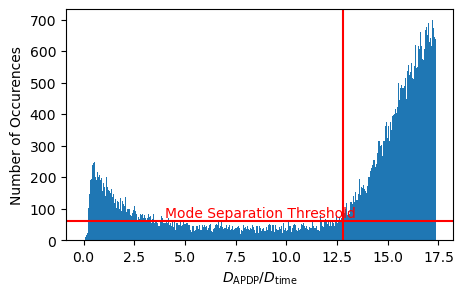

gamma =  12.816667


<Figure size 640x480 with 0 Axes>

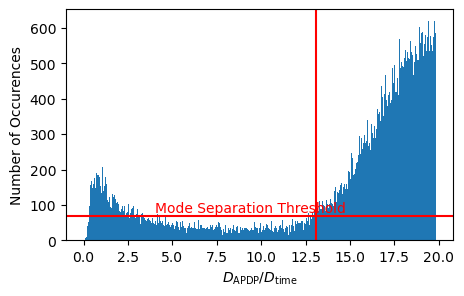

gamma =  13.116667


<Figure size 640x480 with 0 Axes>

In [8]:
# Fuse ADP-based and time-based dissimilarity matrices
dissimilarity_matrix_fused_RAW, scaling_factor_RAW = fuse_adp_time_dissimilarities(timestamp_dissimilarity_matrix, adp_dissimilarity_matrix_RAW)
dissimilarity_matrix_fused_RAW_RECOVERED, scaling_factor_RAW_RECOVERED = fuse_adp_time_dissimilarities(timestamp_dissimilarity_matrix, adp_dissimilarity_matrix_RAW_RECOVERED)

### Step 4: Geodesic Dissimilarity Matrix

In [9]:
def get_geodesic_dissimilarity_matrix(dm):

    n_neighbors = 20
    
    nbrs_alg = sklearn.neighbors.NearestNeighbors(n_neighbors = n_neighbors, metric="precomputed", n_jobs = -1)
    nbrs = nbrs_alg.fit(dm)
    nbg = sklearn.neighbors.kneighbors_graph(nbrs, n_neighbors, metric = "precomputed", mode="distance")

    dissimilarity_matrix_geodesic = np.zeros((nbg.shape[0], nbg.shape[1]), dtype = np.float32)
    
    def shortest_path_worker(todo_queue, output_queue):
        while True:
            index = todo_queue.get()
    
            if index == -1:
                output_queue.put((-1, None))
                break
    
            d = scipy.sparse.csgraph.dijkstra(nbg, directed=False, indices=index)
            output_queue.put((index, d))
    
    with tqdm.tqdm(total = nbg.shape[0]**2) as bar:
        todo_queue = mp.Queue()
        output_queue = mp.Queue()
    
        for i in range(nbg.shape[0]):
            todo_queue.put(i)
        
        for i in range(mp.cpu_count()):
            todo_queue.put(-1)
            p = mp.Process(target = shortest_path_worker, args = (todo_queue, output_queue))
            p.start()
    
        finished_processes = 0
        while finished_processes != mp.cpu_count():
            i, d = output_queue.get()
    
            if i == -1:
                finished_processes = finished_processes + 1
            else:
                dissimilarity_matrix_geodesic[i,:] = d
                bar.update(len(d))

    return dissimilarity_matrix_geodesic

In [10]:
# Geodesic fused dissimilarity matrix
dissimilarity_matrix_geodesic_RAW = get_geodesic_dissimilarity_matrix(dissimilarity_matrix_fused_RAW)
dissimilarity_matrix_geodesic_RAW_RECOVERED = get_geodesic_dissimilarity_matrix(dissimilarity_matrix_fused_RAW_RECOVERED)

100%|██████████| 434764201/434764201 [00:35<00:00, 12364191.07it/s] 


### Visual Evaluation of Dissimilarity Matrix

In [11]:
# Compute distances between groundtruth positions
groundtruth_distance_matrix = scipy.spatial.distance_matrix(groundtruth_positions, groundtruth_positions)

In [12]:
def plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix, distance_matrix, label = None):
	nth_reduction = 10
	dissimilarities_flat = dissimilarity_matrix[::nth_reduction, ::nth_reduction].flatten()
	distances_flat = distance_matrix[::nth_reduction, ::nth_reduction].flatten()
	
	max_distance = np.max(distances_flat)
	bins = np.linspace(0, max_distance, 200)
	bin_indices = np.digitize(distances_flat, bins)
	
	bin_medians = np.zeros(len(bins) - 1)
	bin_25_perc = np.zeros(len(bins) - 1)
	bin_75_perc = np.zeros(len(bins) - 1)
	for i in range(1, len(bins)):
		bin_values = dissimilarities_flat[bin_indices == i]
		bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])
	
	plt.plot(bins[:-1], bin_medians, label = label)
	plt.fill_between(bins[:-1], bin_25_perc, bin_75_perc, alpha=0.5)

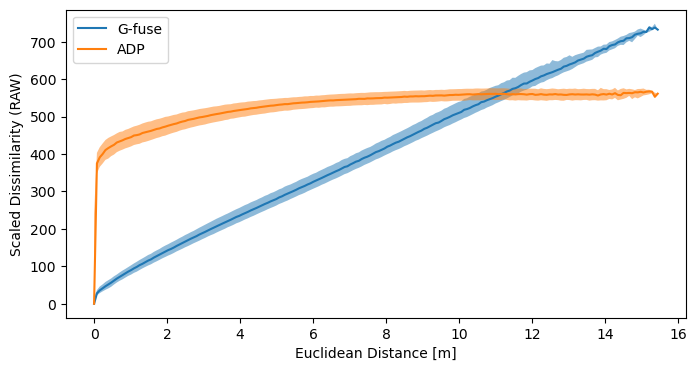

In [13]:
plt.figure(figsize=(8,4))

plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix_geodesic_RAW, groundtruth_distance_matrix, "G-fuse")
plot_dissimilarity_over_euclidean_distance(scaling_factor_RAW * adp_dissimilarity_matrix_RAW, groundtruth_distance_matrix, "ADP")

plt.legend()
plt.xlabel("Euclidean Distance [m]")
plt.ylabel("Scaled Dissimilarity (RAW)")
plt.show()

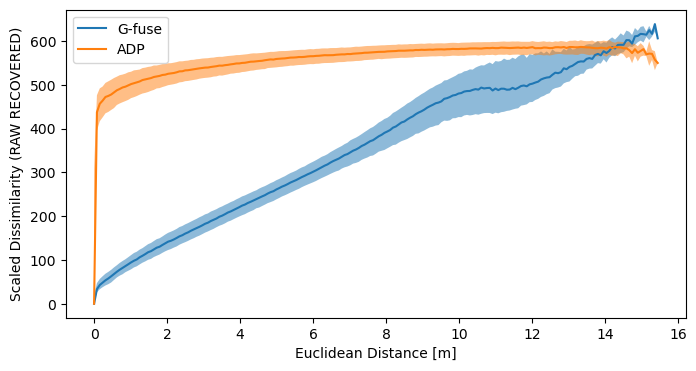

In [14]:
plt.figure(figsize=(8,4))

plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix_geodesic_RAW_RECOVERED, groundtruth_distance_matrix, "G-fuse")
plot_dissimilarity_over_euclidean_distance(scaling_factor_RAW_RECOVERED * adp_dissimilarity_matrix_RAW_RECOVERED, groundtruth_distance_matrix, "ADP")

plt.legend()
plt.xlabel("Euclidean Distance [m]")
plt.ylabel("Scaled Dissimilarity (RAW RECOVERED)")
plt.show()

## Manifold Learning: Finding the Low-Dimensional Representation

## Scenario 1: Training on Original (Raw) CSI

In [15]:
# Feature Engineering Layer
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi):
        # Compute sample autocorrelations for any combination of two antennas in the whole system
        # for the same datapoint and time tap.
        # csi has shape (batchsize, array, antenna row, antenna column, tap)
        sample_autocorrelations = tf.einsum("dbrmt,dbsnt->dtbrmsn", csi, tf.math.conj(csi))
        return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

In [16]:
# Create a dataset of random pairs of datapoints
csi_time_domain_RAW_tensor = tf.constant(csi_time_domain_RAW)
dissimilarity_matrix_geodesic_RAW_tensor = tf.constant(dissimilarity_matrix_geodesic_RAW, dtype = tf.float32)

datapoint_count = tf.shape(csi_time_domain_RAW_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    return (csi_time_domain_RAW_tensor[randA % datapoint_count], csi_time_domain_RAW_tensor[randB % datapoint_count]), dissimilarity_matrix_geodesic_RAW_tensor[randA % datapoint_count, randB % datapoint_count]

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

### The Forward Charting Function: Defining the Neural Network

In [17]:
# Define the channel charting model (Forward Charting Function)
array_count = np.shape(csi_time_domain_RAW)[1]
rows_per_array_count = np.shape(csi_time_domain_RAW)[2]
antennas_per_row_count = np.shape(csi_time_domain_RAW)[3]
tap_count = np.shape(csi_time_domain_RAW)[4]

cc_embmodel_input = tf.keras.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs = cc_embmodel_input, outputs = cc_embmodel_output, name = "ForwardChartingFunction")

### Siamese Network

In [18]:
# Define the Siamese Neural Network
input_A = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")
model.summary()

Model: "SiameseNeuralNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4, 2, 4, 13)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4, 2, 4, 13)]        0         []                            
                                                                                                  
 ForwardChartingFunction (F  (None, 2)                    7522114   ['input_1[0][0]',             
 unctional)                                                          'input_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 4)                    0         ['ForwardCh

### Siamese Loss

In [19]:
# Define the Siamese Loss Function
dissimilarity_margin = np.quantile(dissimilarity_matrix_geodesic_RAW, 0.01)

def siamese_loss(y_true, y_pred):
    y_true = y_true[:,0]
    pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
    distances_pred = tf.math.reduce_euclidean_norm(pos_A - pos_B, axis = 1)

    return tf.reduce_mean(tf.square(distances_pred - y_true) / (y_true + dissimilarity_margin))

### Training

In [20]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = siamese_loss, optimizer = optimizer)

# Training the model
samples_per_session = 150000
learning_rates = [1e-2, 1e-2, 8e-3, 4e-3, 1e-3, 5e-4, 2e-4, 1e-4]
batch_size = [1500, 1500, 2000, 2000, 3000, 4000, 5000, 6000]

for l in range(len(learning_rates)):
    print("\nTraining Session ", l + 1, "\nBatch Size: ", batch_size[l], "\nLearning rate: ", learning_rates[l])
    
    # Fit model
    optimizer.learning_rate.assign(learning_rates[l])
    model.fit(random_pair_dataset.batch(batch_size[l]).prefetch(tf.data.AUTOTUNE), steps_per_epoch = samples_per_session // batch_size[l])


Training Session  1 
Batch Size:  1500 
Learning rate:  0.01
100/100 [==============================] - 7s 25ms/step - loss: 134.9457

Training Session  2 
Batch Size:  1500 
Learning rate:  0.01
100/100 [==============================] - 3s 26ms/step - loss: 8.9668

Training Session  3 
Batch Size:  2000 
Learning rate:  0.008
75/75 [==============================] - 3s 34ms/step - loss: 3.0872

Training Session  4 
Batch Size:  2000 
Learning rate:  0.004
75/75 [==============================] - 3s 34ms/step - loss: 2.6670

Training Session  5 
Batch Size:  3000 
Learning rate:  0.001
50/50 [==============================] - 3s 50ms/step - loss: 2.4894

Training Session  6 
Batch Size:  4000 
Learning rate:  0.0005
37/37 [==============================] - 3s 70ms/step - loss: 2.4377

Training Session  7 
Batch Size:  5000 
Learning rate:  0.0002
30/30 [==============================] - 3s 85ms/step - loss: 2.4317

Training Session  8 
Batch Size:  6000 
Learning rate:  0.0001
25/25 

## Evaluation

In [21]:
# Function to apply affine transformation to channel chart positions
def affine_transform_channel_chart(groundtruth_pos, channel_chart_pos):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:,:-1]
    A, res, rank, s = np.linalg.lstsq(pad(channel_chart_pos), pad(groundtruth_pos), rcond = None)
    transform = lambda x: unpad(np.dot(pad(x), A))
    return transform(channel_chart_pos)

# Function to plot CDF of localization errors
def plot_cdf(positions, reference_positions, title = None):
    errorvectors = reference_positions[:,:2] - positions
    errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
    count, bins_count = np.histogram(errors, bins=200)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    bins_count[0] = 0
    cdf = np.append([0], cdf)

    plt.figure(figsize=(5, 4))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.plot(bins_count, cdf)
    plt.xlim((0, 2))
    plt.xlabel("Absolute Localization Error [m]")
    plt.ylabel("CDF")
    plt.grid()
    plt.show()

## Evaluation on Original (Raw) CSI (Test Set)

652/652 [==============================] - 1s 2ms/step


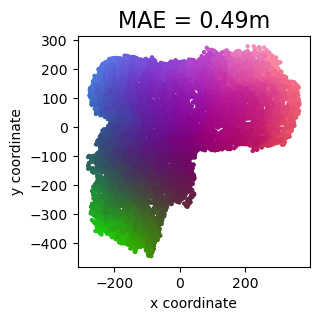

In [22]:
# Infer channel chart positions for RAW CSI
channel_chart_positions_RAW_test = cc_embmodel.predict(tf.constant(csi_time_domain_RAW_test))

# Transform channel chart positions to match the coordinates of the ground truth positions
channel_chart_positions_transformed_RAW_test = affine_transform_channel_chart(groundtruth_positions_test, channel_chart_positions_RAW_test)

# Calculate errors and plot channel chart for RAW CSI
errorvectors = groundtruth_positions_test - channel_chart_positions_transformed_RAW_test
errors_RAW_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RAW_test), 2)

plot_colorized(channel_chart_positions_RAW_test, groundtruth_positions_test, title = "MAE = " + str(mae) + "m", show = False)
plt.savefig("results/channel_charting/cc_errors_RAW_test",bbox_inches='tight',dpi=300)
plt.show()

## Evaluation on Obfuscated CSI (Test Set)

652/652 [==============================] - 1s 2ms/step


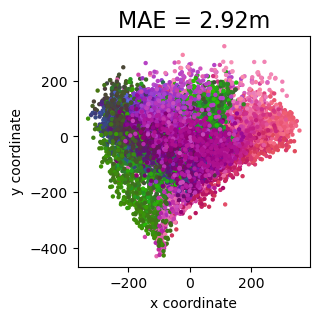

In [23]:
# Infer channel chart positions for RAW OBFUSCATED CSI
channel_chart_positions_OBFUSCATED_test = cc_embmodel.predict(tf.constant(csi_time_domain_OBFUSCATED_test))

# Transform channel chart positions to match the coordinates of the ground truth positions
channel_chart_positions_transformed_OBFUSCATED_test = affine_transform_channel_chart(groundtruth_positions_test, channel_chart_positions_OBFUSCATED_test)

# Calculate errors and plot channel chart for RAW OBFUSCATED CSI
errorvectors = groundtruth_positions_test - channel_chart_positions_transformed_OBFUSCATED_test
errors_OBFUSCATED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_OBFUSCATED_test), 2)

plot_colorized(channel_chart_positions_OBFUSCATED_test, groundtruth_positions_test, title = "MAE = " + str(mae) + "m", show = False)
plt.savefig("results/channel_charting/cc_errors_OBFUSCATED_test",bbox_inches='tight',dpi=300)
plt.show()

## Scenario 2: Training on Recovered Original (Raw) CSI

In [24]:
# Feature Engineering Layer
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi):
        # Compute sample autocorrelations for any combination of two antennas in the whole system
        # for the same datapoint and time tap.
        # csi has shape (batchsize, array, antenna row, antenna column, tap)
        sample_autocorrelations = tf.einsum("dbrmt,dbsnt->dtbrmsn", csi, tf.math.conj(csi))
        return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

In [25]:
# Create a dataset of random pairs of datapoints for RAW RECOVERED CSI
csi_time_domain_RAW_RECOVERED_tensor = tf.constant(csi_time_domain_RAW_RECOVERED)
dissimilarity_matrix_geodesic_RAW_RECOVERED_tensor = tf.constant(dissimilarity_matrix_geodesic_RAW_RECOVERED, dtype = tf.float32)

datapoint_count = tf.shape(csi_time_domain_RAW_RECOVERED_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    return (csi_time_domain_RAW_RECOVERED_tensor[randA % datapoint_count], csi_time_domain_RAW_RECOVERED_tensor[randB % datapoint_count]), dissimilarity_matrix_geodesic_RAW_RECOVERED_tensor[randA % datapoint_count, randB % datapoint_count]

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

### The Forward Charting Function: Defining the Neural Network

In [26]:
# Define the channel charting model (Forward Charting Function)
array_count = np.shape(csi_time_domain_RAW_RECOVERED)[1]
rows_per_array_count = np.shape(csi_time_domain_RAW_RECOVERED)[2]
antennas_per_row_count = np.shape(csi_time_domain_RAW_RECOVERED)[3]
tap_count = np.shape(csi_time_domain_RAW_RECOVERED)[4]

cc_embmodel_input = tf.keras.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs = cc_embmodel_input, outputs = cc_embmodel_output, name = "ForwardChartingFunction")

### Siamese Network

In [27]:
# Define the Siamese Neural Network
input_A = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")
model.summary()

Model: "SiameseNeuralNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 4, 2, 4, 13)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 4, 2, 4, 13)]        0         []                            
                                                                                                  
 ForwardChartingFunction (F  (None, 2)                    7522114   ['input_3[0][0]',             
 unctional)                                                          'input_4[0][0]']             
                                                                                                  
 concatenate_1 (Concatenate  (None, 4)                    0         ['ForwardCh

In [28]:
# Define the Siamese Loss Function
dissimilarity_margin = np.quantile(dissimilarity_matrix_geodesic_RAW, 0.01)

def siamese_loss(y_true, y_pred):
    y_true = y_true[:,0]
    pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
    distances_pred = tf.math.reduce_euclidean_norm(pos_A - pos_B, axis = 1)

    return tf.reduce_mean(tf.square(distances_pred - y_true) / (y_true + dissimilarity_margin))

### Training

In [29]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = siamese_loss, optimizer = optimizer)

# Training the model for RAW RECOVERED CSI (slighly adapted training parameters)
samples_per_session = 150000
learning_rates = [1e-1, 1e-1, 8e-2, 4e-2, 2e-2, 1e-2, 1e-3, 1e-4]
batch_size = [1000, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

for l in range(len(learning_rates)):
    print("\nTraining Session ", l + 1, "\nBatch Size: ", batch_size[l], "\nLearning rate: ", learning_rates[l])
    
    # Fit model
    optimizer.learning_rate.assign(learning_rates[l])
    model.fit(random_pair_dataset.batch(batch_size[l]).prefetch(tf.data.AUTOTUNE), steps_per_epoch = samples_per_session // batch_size[l])


Training Session  1 
Batch Size:  1000 
Learning rate:  0.1
150/150 [==============================] - 7s 16ms/step - loss: 17.9403

Training Session  2 
Batch Size:  1000 
Learning rate:  0.1
150/150 [==============================] - 3s 17ms/step - loss: 6.0084

Training Session  3 
Batch Size:  1500 
Learning rate:  0.08
100/100 [==============================] - 3s 26ms/step - loss: 5.5955

Training Session  4 
Batch Size:  2000 
Learning rate:  0.04
75/75 [==============================] - 3s 34ms/step - loss: 5.2633

Training Session  5 
Batch Size:  3000 
Learning rate:  0.02
50/50 [==============================] - 3s 53ms/step - loss: 5.1659

Training Session  6 
Batch Size:  4000 
Learning rate:  0.01
37/37 [==============================] - 3s 69ms/step - loss: 5.0988

Training Session  7 
Batch Size:  5000 
Learning rate:  0.001
30/30 [==============================] - 3s 85ms/step - loss: 5.1044

Training Session  8 
Batch Size:  6000 
Learning rate:  0.0001
25/25 [======

## Evaluation on Original (Raw) CSI (Test Set)

652/652 [==============================] - 1s 2ms/step


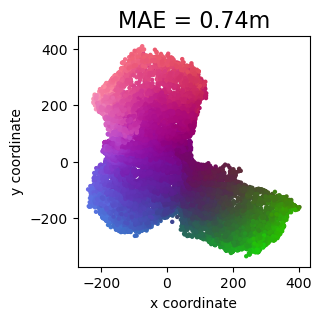

In [30]:
# Infer channel chart positions for RAW RECOVERED CSI
channel_chart_positions_RAW_RECOVERED_test = cc_embmodel.predict(tf.constant(csi_time_domain_RAW_RECOVERED_test))

# Transform channel chart positions to match the coordinates of the ground truth positions
channel_chart_positions_transformed_RAW_RECOVERED_test = affine_transform_channel_chart(groundtruth_positions_test, channel_chart_positions_RAW_RECOVERED_test)

# Calculate errors and plot channel chart for RAW RECOVERED CSI
errorvectors = groundtruth_positions_test - channel_chart_positions_transformed_RAW_RECOVERED_test
errors_RAW_RECOVERED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RAW_RECOVERED_test), 2)

plot_colorized(channel_chart_positions_RAW_RECOVERED_test, groundtruth_positions_test, title = "MAE = " + str(mae) + "m", show = False)
plt.savefig("results/channel_charting/cc_errors_RAW_RECOVERED_test",bbox_inches='tight',dpi=300)
plt.show()

## Evaluation on Recovered Obfuscated CSI (Test Set)

652/652 [==============================] - 1s 2ms/step


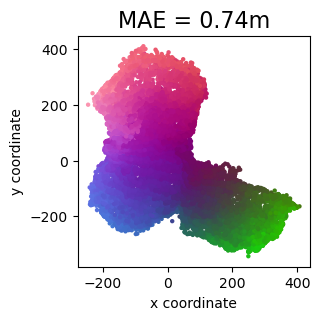

In [31]:
# Infer channel chart positions for RECOVERED CSI
channel_chart_positions_RECOVERED_test = cc_embmodel.predict(tf.constant(csi_time_domain_RECOVERED_test))

# Transform channel chart positions to match the coordinates of the ground truth positions
channel_chart_positions_transformed_RECOVERED_test = affine_transform_channel_chart(groundtruth_positions_test, channel_chart_positions_RECOVERED_test)

# Calculate errors and plot channel chart for RECOVERED CSI
errorvectors = groundtruth_positions_test - channel_chart_positions_transformed_RECOVERED_test
errors_RECOVERED_test = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
mae = np.round(np.mean(errors_RECOVERED_test), 2)

plot_colorized(channel_chart_positions_RECOVERED_test, groundtruth_positions_test, title = "MAE = " + str(mae) + "m", show = False)

plt.savefig("results/channel_charting/cc_errors_RECOVERED_test",bbox_inches='tight',dpi=300)
plt.show()